# This notebook plots the Steiner convective cell functions 
## It uses the thresholds specified in the cell tracking config.yml file

In [37]:
import yaml
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyflextrkr.steiner_func import make_dilation_step_func, peakedness
%matplotlib inline

In [107]:
# Config file for cell tracking
config_file = '/global/homes/f/feng045/program/PyFLEXTRKR/config/config_csapr500m_example.yml'
# Output figure directory
figdir = '/global/cfs/cdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'

# Read configuration from yaml file
stream = open(config_file, "r")
config = yaml.full_load(stream)

In [5]:
config

{'run_idfeature': True,
 'run_advection': True,
 'run_tracksingle': True,
 'run_gettracks': True,
 'run_trackstats': True,
 'run_mapfeature': True,
 'run_parallel': 1,
 'nprocesses': 4,
 'dask_tmp_dir': '/tmp',
 'timeout': 360,
 'startdate': '20190125.1200',
 'enddate': '20190126.0000',
 'time_format': 'yyyymodd.hhmmss',
 'databasename': 'taranis_corcsapr2cfrppiqcM1.c1.',
 'clouddata_path': 'INPUT_DIR/',
 'root_path': 'TRACK_DIR/',
 'tracking_path_name': 'tracking',
 'stats_path_name': 'stats',
 'pixel_path_name': 'celltracking',
 'terrain_file': 'INPUT_DIR/CSAPR2_Taranis_Gridded_500m.Terrain_RangeMask.nc',
 'elev_varname': 'hgt',
 'rangemask_varname': 'mask110',
 'feature_type': 'radar_cells',
 'advection_field_threshold': 10,
 'advection_med_filt_len': 9,
 'advection_max_movement_mps': 60,
 'advection_mask_method': 'greater',
 'advection_buffer': 30,
 'advection_size_threshold': 10,
 'advection_tiles': [1, 1],
 'advection_filename': 'advection_',
 'absConvThres': 60,
 'minZdiff': 10,

In [7]:
# Get useful variables
absConvThres = config['absConvThres']
minZdiff = config['minZdiff']
truncZconvThres = config['truncZconvThres']
mindBZuse = config['mindBZuse']
dBZforMaxConvRadius = config['dBZforMaxConvRadius']
conv_rad_increment = config['conv_rad_increment']
conv_rad_start = config['conv_rad_start']
bkg_refl_increment = config['bkg_refl_increment']
maxConvRadius = config['maxConvRadius']
radii_expand = config['radii_expand']
weakEchoThres = config['weakEchoThres']
bkgrndRadius = config['bkgrndRadius']
min_corearea = config['min_corearea']

In [98]:
print(f'mindBZuse: {mindBZuse}')
print(f'dBZforMaxConvRadius: {dBZforMaxConvRadius}')
print(f'bkg_refl_increment: {bkg_refl_increment}')
print(f'conv_rad_increment: {conv_rad_increment}')
print(f'conv_rad_start: {conv_rad_start}')
print(f'maxConvRadius: {maxConvRadius}')

mindBZuse: 25
dBZforMaxConvRadius: 60
bkg_refl_increment: 5
conv_rad_increment: 0.5
conv_rad_start: 1.0
maxConvRadius: 5


## Plot Convective Cell Expansion Radius Function

In [97]:
# Convert radii_expand from a list to a numpy array
radii_expand = np.array(radii_expand)

# Make step function for convective radius dilation
bkg_bin, conv_rad_bin = make_dilation_step_func(
    mindBZuse,
    dBZforMaxConvRadius,
    bkg_refl_increment,
    conv_rad_increment,
    conv_rad_start,
    maxConvRadius,
)
# Repeat first value in array for plotting
conv_rad_bin = np.insert(conv_rad_bin, 0, conv_rad_bin[0])

In [99]:
# Steiner et al. (1995) step function
bkg_bin_steiner, conv_rad_bin_steiner = make_dilation_step_func(
    25,
    60.0,
    5.0,
    1.0,
    1.0,
    5.0,
)
# Repeat first value in array for plotting
conv_rad_bin_steiner = np.insert(conv_rad_bin_steiner, 0, conv_rad_bin_steiner[0])

In [94]:
bkg_bin_steiner, conv_rad_bin_steiner

(array([  0.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60., 100.]),
 array([1., 1., 2., 3., 4., 5., 5., 5., 5., 5.]))

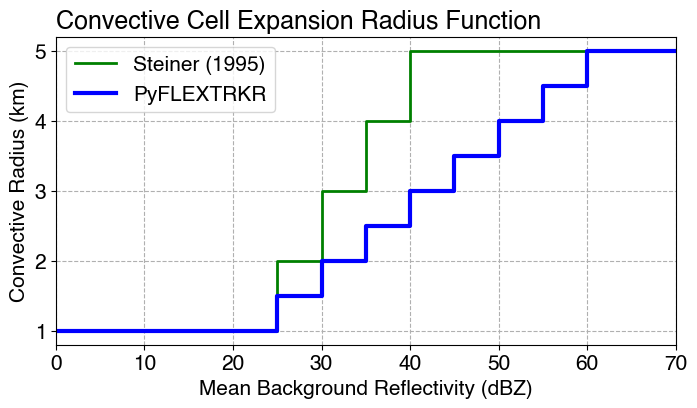

In [115]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'

fig = plt.figure(figsize=[8,4], dpi=100)
ax = plt.subplot()
ax.step(bkg_bin_steiner, conv_rad_bin_steiner, '-', lw=2, color='g', label='Steiner (1995)')
ax.step(bkg_bin, conv_rad_bin, '-', lw=3, color='b', label='PyFLEXTRKR')
ax.set_xlabel('Mean Background Reflectivity (dBZ)')
ax.set_ylabel('Convective Radius (km)')
ax.set_title('Convective Cell Expansion Radius Function', loc='left')
ax.grid(ls='--')
ax.legend()
ax.set_xlim(0, 70)
# ax.set_ylim(0, 6)

figname = f'{figdir}convective_radius_dilation_stepfunction.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

## Plot Convective Core Peakedness Function

In [47]:
# Make background reflectivity array
refl_bkg = np.linspace(-10, 70, 1000)
mask_goodvalues = np.ones(len(refl_bkg))

# Make peakedness curve
peak = peakedness(refl_bkg, mask_goodvalues, minZdiff, absConvThres)
# Steiner et al. (1995) peakedness curve
peak_steiner = peakedness(refl_bkg, mask_goodvalues, minZdiff, 42.23)

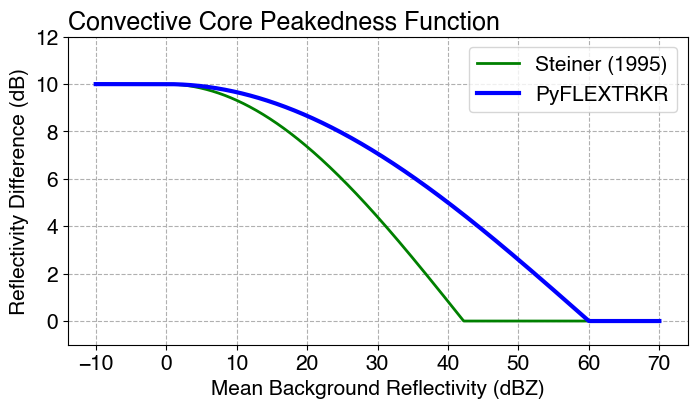

In [113]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'

fig = plt.figure(figsize=[8,4], dpi=100)
ax = plt.subplot()
ax.plot(refl_bkg, peak_steiner, '-', lw=2, color='g', label='Steiner (1995)')
ax.plot(refl_bkg, peak, '-', lw=3, color='b', label='PyFLEXTRKR')
ax.set_xlabel('Mean Background Reflectivity (dBZ)')
ax.set_ylabel('Reflectivity Difference (dB)')
ax.set_title('Convective Core Peakedness Function', loc='left')
ax.grid(ls='--')
ax.set_ylim(-1, 12)
ax.legend()

figname = f'{figdir}reflectivity_peakedness_curve.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')